In [1]:
#using Cxx

include("bullet_collision.jl")

using MAT

using RigidBodySim
using RigidBodyDynamics

using MeshCat
using MeshCatMechanisms
using GeometryTypes
import ColorTypes: RGB, RGBA

import StaticArrays: SVector

#using PyPlot

println("Loaded all packages")

HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/37963de6d08bd2e6fe9e206e2e9943687644a3d1-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/37963de6d08bd2e6fe9e206e2e9943687644a3d1-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

INFO: Loading HttpServer methods...


Loaded all packages


In [1]:
# define Astrobee as sphere
astrobee = HyperSphere(Point3f0(0.,0.,0.), 0.3f0) # radius = 0.3m

btrobot_ = BT.geometry_type_to_BT(astrobee) # bullet representation of astrobee
btworld_ = BT.collision_world(SVector{3}(-100.,-100.,-100.), 
        SVector{3}(100.,100.,100.)) # workspace bounds

env = BT.BulletStaticEnvironment(btrobot_, btworld_) # bullet representation of environment
fieldnames(env) # env.convex_env_components is currently empty since no obstacles have been added

LoadError: [91mUndefVarError: HyperSphere not defined[39m

In [3]:
# define obstacles using GeometryTypes
obstacles = []
push!(obstacles, HyperSphere(Point3f0(1.,1.,1.), 0.1f0))
#push!(obstacles, HyperSphere(Point3f0(2.,2,2), 0.2f0))
push!(obstacles, HyperRectangle(Vec3f0(0.5,0.1,0),Vec3f0(0.4,1.8,2.2)))
#push!(obstacles, HyperRectangle(Vec3f0(2.,2.,2.),Vec3f0(1.,1.,1.)))

# add obstacles to Bullet environment
for obs in obstacles
    BT.add_collision_object!(env, BT.geometry_type_to_BT(obs))
end
env.convex_env_components # added four obstacles to Bullet environment

2-element Array{Cxx.CppPtr{Cxx.CxxQualType{Cxx.CppBaseType{:btCollisionObject},(false, false, false)},(false, false, false)},1}:
 (class btCollisionObject *) @0x0000000007d3f270

 (class btCollisionObject *) @0x0000000007b965d0


In [4]:
# how to query Bullet for the distance to an obstacle
pt = BT.convex_hull([SVector{3}(0.,0.0,0.)]) # represent a point using convex hull
pt = BT.convex_hull([SVector{3}(1.1,1.1,1.1)]) # represent a point using convex hull

min_distance = Inf
for obs in env.convex_env_components
    distance_to_obs = max(BT.distance(pt,obs)[1], 0) # set distance to zero if inside obstacle
    if min_distance > distance_to_obs
        min_distance = distance_to_obs
    end
end
min_distance
println("finished querying Bullet for the distance to an obstacle")
println(min_distance)
obstacles

finished querying Bullet for the distance to an obstacle
0.07320512


2-element Array{Any,1}:
 GeometryTypes.HyperSphere{3,Float32}(Float32[1.0, 1.0, 1.0], 0.1)                      
 GeometryTypes.HyperRectangle{3,Float32}(Float32[0.5, 0.1, 0.0], Float32[0.4, 1.8, 2.2])

In [5]:
# STOMP starter code
using Distributions
srand(123)

# parameters
weight_torques = 1e-7
weight_ref = 1e-3 # cost on distance to Q0
body_radius = 0.05
# epsilon_obstacles = 1e-2 # redefined later depending on discretization of distances table
delta_cost_stop = 1e-3
nb_iter_max = 30
h = 10 # hyperparameter, replaces lambda (see eq. 11)
p = 3  # statespace dimension
N = 100 # number of discretized points (including initial/final)
NB_MOTORS = p
T = 5 # horizon, in [s] (NOTE: 100samples/sec looks like what they used in paper)
dt = T/N # timestep
K = 100 # number noise trajectories
x0,xf = zeros(p), 2*ones(p) # initial/final positions
q0,qf = copy(x0), copy(xf)  # initial/final configurations
# Initial trajectory (linear interpolation from initial to final conf., including those)
Q0 = zeros(p,N) # parameters
for idx in 1:p
  Q0[idx,:] = collect(linspace(q0[idx],qf[idx],N))
end

# Todo take into account the constant part!
A = zeros(N,N)
A = A - 30.0/12.0*diagm(ones(N))
A = A + 16.0/12.0*diagm(ones(N-1),1) + 16.0/12.0*diagm(ones(N-1),-1)
A = A - 1/12.0*diagm(ones(N-2),2) - 1/12.0*diagm(ones(N-2),-2)
A = A/(dt^2)

R = A'*A
Rinv = inv(R)
Rinv = (Rinv+ Rinv')/2; # Make it symmetrical, it's not before (rounding errors)
M = copy(Rinv)
for col_i = 1:size(M,2)
    max_col_i = maximum(M[:, col_i])
    M[:,col_i] = M[:,col_i] / (max_col_i*N)
end


In [6]:
# compute distances to all objects

# returns the euclidean signed distance from the given 3d point to the closest object
function dist_pt2obj{T}(pt_3d::Vector{T})
    min_distance = Inf
    for obs in env.convex_env_components
        distance_to_obs = max(BT.distance(pt_3d,obs)[1], 0) # zero if inside obstacle
        if min_distance > distance_to_obs
            min_distance = distance_to_obs
        end
    end
end


#### =Put A MINUS OBSATLCES EPSILON
NX = 101 # number of points along each dimension
X_MIN, X_MAX = x0-(xf-x0)/4, xf+(xf-x0)/4
DX = (X_MAX[1]-X_MIN[1])
dx = DX/(NX-1)
println("The distances table will have a precision of $(dx/2) meters")
epsilon_obstacles = dx/2
function create_table_distances()
    for xid = 1:NX
        println("[create_table_distancesxid] xid: $xid")
        x = X_MIN[1] + (xid-1)*DX/(NX-1)
        for yid = 1:NX
            y = X_MIN[2] + (yid-1)*DX/(NX-1)
            for zid = 1:NX
                z = X_MIN[3] + (zid-1)*DX/(NX-1)
                pt_coords_3d = [x,y,z]
                min_distance = Inf
                for obs in env.convex_env_components
                    pt = BT.convex_hull([SVector{3}(pt_coords_3d)]) # represent a point using convex hull
                    distance_to_obs = BT.distance(pt,obs)[1]# zero if inside obstacle
                    if min_distance > distance_to_obs
                        min_distance = distance_to_obs
                    end
                end
                DIST2OBS_MAT[xid,yid,zid] = min_distance
            end
        end
    end   
    return DIST2OBS_MAT
end
# table with all signed euclidean distances to the closest obstacle for all points
DIST2OBS_MAT = zeros(NX,NX,NX)
DIST2OBS_MAT = create_table_distances();

The distances table will have a precision of 0.015 meters
[create_table_distancesxid] xid: 1
[create_table_distancesxid] xid: 2
[create_table_distancesxid] xid: 3
[create_table_distancesxid] xid: 4
[create_table_distancesxid] xid: 5
[create_table_distancesxid] xid: 6
[create_table_distancesxid] xid: 7
[create_table_distancesxid] xid: 8
[create_table_distancesxid] xid: 9
[create_table_distancesxid] xid: 10
[create_table_distancesxid] xid: 11
[create_table_distancesxid] xid: 12
[create_table_distancesxid] xid: 13
[create_table_distancesxid] xid: 14
[create_table_distancesxid] xid: 15
[create_table_distancesxid] xid: 16
[create_table_distancesxid] xid: 17
[create_table_distancesxid] xid: 18
[create_table_distancesxid] xid: 19
[create_table_distancesxid] xid: 20
[create_table_distancesxid] xid: 21
[create_table_distancesxid] xid: 22
[create_table_distancesxid] xid: 23
[create_table_distancesxid] xid: 24
[create_table_distancesxid] xid: 25
[create_table_distancesxid] xid: 26
[create_table_d

In [7]:

function dist2obs{T}(qconf::Vector{T})
    # ASSUMES NO KINEMATICS AND THAT qconf is in R^3 and describes 3d position!
    pt_3d = qconf
    
    # get point given configuration and kinematics...
    pt_coords_3d = pt_3d
    pt = BT.convex_hull([SVector{3}(pt_coords_3d)]) # represent a point using convex hull

    min_distance = Inf
    for obs in env.convex_env_components
#         distance_to_obs = max(BT.distance(pt,obs)[1], 0) # zero if inside obstacle
        distance_to_obs = BT.distance(pt,obs)[1]
        if min_distance > distance_to_obs
            min_distance = distance_to_obs
        end
    end
    
    return min_distance
end

dist2obs (generic function with 1 method)

In [8]:
function get_dist2obs{T}(pt_3d::Vector{T})
    idx_in_tab = zeros(3);
    for dim in 1:3
        idx_in_tab[dim] = (pt_3d[dim]-X_MIN[dim]) / DX
        if idx_in_tab[dim] < 0
            #println("not enough")
            idx_in_tab[dim] = 1
        elseif idx_in_tab[dim] > 1
            #println("too much")
            idx_in_tab[dim] = NX
        else
            idx_in_tab[dim] = 1+idx_in_tab[dim]*(NX-1)
        end
    end
    idx_in_tab = round.(Int,idx_in_tab)
    x = X_MIN[1] + (idx_in_tab[1]-1)*DX/(NX-1)
    y = X_MIN[2] + (idx_in_tab[2]-1)*DX/(NX-1)
    z = X_MIN[3] + (idx_in_tab[3]-1)*DX/(NX-1)
    #println("index in tab: $idx_in_tab located at [$x $y $z]")
    return DIST2OBS_MAT[idx_in_tab[1],idx_in_tab[2],idx_in_tab[3]]
end

a = ones(3)
a[1] = 1
a[2] = 1
a[3] = 1.31
width_a = 0.2f0
dist_a = get_dist2obs(a)

0.10000001639127731

In [6]:
# DEBUG
a = ones(3)
a[1] = 0.92
a[2] = 1
a[3] = 1.51
width_a = 0.2f0
dist_a = get_dist2obs(a)
dist_a2 = dist2obs(a)
println("x0,xf: $x0 , $xf")
println("a: $a , width_a: $width_a")
println("dist_a: $dist_a diff: $(max(epsilon_obstacles+width_a-dist_a, 0))")
println("dist_a2: $(dist_a2) diff: $(max(1e-3+width_a-dist_a2, 0))")
println("max... : $(max(epsilon_obstacles+width_a-dist_a, 0))")

# plot scene
vis = Visualizer()
vis[:obstacles]
for (idx,obs) in enumerate(obstacles)
    setobject!(vis[:obstacles][Symbol(string("obs",idx))], 
        Object(obs,MeshBasicMaterial(color=RGBA(1.0,0.,0.,1.))))
end
vis[:robot]
setobject!(vis[:robot][:Astrobee], 
    Object(astrobee,MeshBasicMaterial(color=RGBA(0,1.0,0.,1.))))
setobject!(vis[:samples][Symbol(string("position",1))], 
    Object(HyperSphere(Point3f0(a), width_a),
    MeshBasicMaterial(color=RGB(0.,0.,1.))))
in_cell = true
in_cell ? IJuliaCell(vis) : open(vis)

LoadError: [91mUndefVarError: get_dist2obs not defined[39m

In [10]:
# Computes the velocity magnitudes for each 3d point in 'points'
function compute_velocities_mag{T}(points::Matrix{T})
    diff_mat_vel = zeros(N,N)
    diff_mat_vel = diagm(ones(N)) - diagm(ones(N-1),-1); diff_mat_vel[1,1] = 0;
    diff_mat_vel = diff_mat_vel / dt
    
    velocities = similar(points);
    for dim=1:p
        velocities[dim,:] = (diff_mat_vel * points[dim,:])'
    end

    vel_mag = zeros(N)
    for i=1:N
        vel_mag[i] = sqrt(sum(velocities[:,i].^2))
    end
    
    return vel_mag
end
# Compute all velocities
velocities_mag = zeros(N)
velocities_mag = compute_velocities_mag(Q0)

# Computes the torques required for each motor (cost)
function compute_torques{T}(Q::Matrix{T}) # configurations
    # TODO CHANGE THAT, REPLACE WITH INVERSE DYNAMICS ALGORITHMS, see eq (15)
        
    # put inverse dynamics here
    # put inverse dynamics here
    # put inverse dynamics here
    Q_accels = zeros(p,N)
    for dim=1:p
        Q_accels[dim,:] = A * Q[dim, :]
    end
    torques = zeros(NB_MOTORS,N) # torques of each motor for each timestep
    for nidx=1:N
    for motor_i = 1:NB_MOTORS
        if motor_i <= p
            torques[motor_i,:] = sum(Q_accels[:,nidx].^2)
        end
    end
    end
    # put inverse dynamics here
    # put inverse dynamics here
    # put inverse dynamics here
        
    return torques
end
# Compute all velocities
torques = zeros(NB_MOTORS,N)
torques = compute_torques(Q0)



# Cost function. Returns the cost for a given configuration qconf
# and the velocity of the corresponding qconf identified by id_vel (precomputed in velocities_mag)
function cost{T}(qconf::Vector{T}, id_vel::Any, nidx::Any)
#     dist = dist2obs(qconf)
    dist = get_dist2obs(qconf)
    #println("cost{T}: min dist from $qconf is $dist")
    
    # obstacle cost (eq 13)
    cost_obs = max(epsilon_obstacles+body_radius-dist, 0)*velocities_mag[id_vel]
    
    # joint torques costs
    cost_torques = weight_torques*sum(abs.(torques[:,nidx]))
#     cost_torques = 0
    
    # distance to reference cost
    cost_qconf_ref = weight_ref*sqrt(sum((qconf-Q0[:,nidx]).^2))
#     cost_qconf_ref = 0
    
    Jm = 0 + cost_obs + cost_torques + cost_qconf_ref
    return Jm
end

# Cost function. Returns the cost for a given configuration qconf
# and the velocity of the corresponding qconf identified by id_vel (precomputed in velocities_mag)
function cost_println{T}(qconf::Vector{T}, id_vel::Any, nidx::Any)
#     dist = dist2obs(qconf)
    dist = get_dist2obs(qconf)
    #println("cost{T}: min dist from $qconf is $dist")
    
    # obstacle cost (eq 13)
    cost_obs = max(epsilon_obstacles+body_radius-dist, 0)*velocities_mag[id_vel]
    
    # joint torques costs
    cost_torques = weight_torques*sum(abs.(torques[:,nidx]))
#     cost_torques = 0
    
    # distance to reference cost
    cost_qconf_ref = weight_ref*sqrt(sum((qconf-Q0[:,nidx]).^2))
#     cost_qconf_ref = 0
    
    Jm = 0 + cost_obs + cost_torques + cost_qconf_ref
    println("Contribution of costs: ")
    println("cost_obs:       $(cost_obs/Jm)%")
    println("cost_torques:   $(cost_torques/Jm)%")
    println("cost_qconf_ref: $(cost_qconf_ref/Jm)%")
    return Jm
end

cost_println (generic function with 1 method)

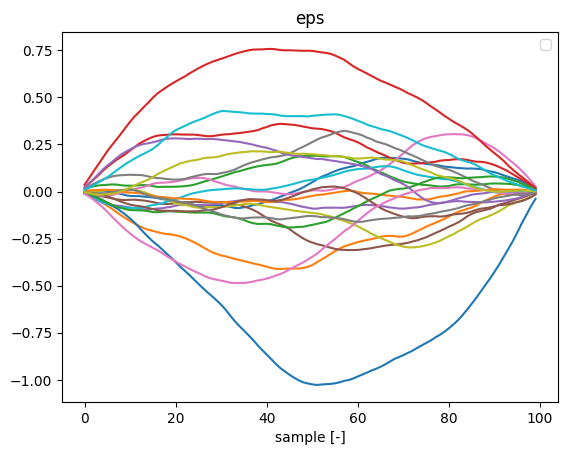

No handles with labels found to put in legend.


PyObject Text(0.5,1,'eps')

In [11]:
# debug samples generation
using PyPlot

Dist = MvNormal(zeros(N),Rinv) # create normal distribution
eps = zeros(p,N,K)
for kidx in 1:K # for each trajectory
    eps[:,:,kidx] = rand(Dist,p)'
end

PyPlot.figure()
for kidx in 1:min(K,20)
    PyPlot.plot(eps[1,:,kidx])
end
PyPlot.legend(loc="best")
PyPlot.xlabel("sample [-]"); PyPlot.title("eps")


In [12]:
# ********************************************
# ****** MAIN SCRIPT - IMPLEMENTS STOMP ******
# ********************************************
# note: for all variables, subscripts are in this order: dimension(p) x samples(N) x trajectoryId(K)
Dist = MvNormal(zeros(N),Rinv) # create normal distribution
Q = copy(Q0) # configuration
velocities_mag = compute_velocities_mag(Q)
torques = compute_torques(Q)

Jtot = 0+delta_cost_stop+1e-5; 
for dim in 1:p; Jtot = Jtot + 0.5 * Q[p,:]' * R * Q[p,:]; end
for nidx = 1:N; Jtot = Jtot + cost(Q[:,nidx],nidx, nidx); end; 
println("Initial cost: $(Jtot/N)")
Jprev = 0
iter_i = 0;

println("entering loop")
while (abs(Jprev-Jtot) >= delta_cost_stop) && (iter_i <= 200)
    println("Starting iter $iter_i")
    Jprev = copy(Jtot)
    iter_i = iter_i+1
    
    # 1) Create K noisy trajectories
    Qperturbed = zeros(p,N,K) # configuration trajectory (in time, length N) for each dimension
    eps = zeros(p,N,K)
    for kidx in 1:K # for each trajectory
        eps[:,:,kidx] = rand(Dist,p)'
        for dim in 1:p 
            Qperturbed[dim,:,kidx]= Q[dim,:] + eps[dim,:,kidx]
        end
    end

    # 2) Compute costs and probability metrics
    # a)
    S = zeros(N,K)
    P = zeros(N,K)
    for kidx in 1:K # for each trajectory
        velocities_mag = compute_velocities_mag(Qperturbed[:,:,kidx])
        torques = compute_torques(Qperturbed[:,:,kidx])
        for nidx in 1:N # get cost for each sample
            S[nidx,kidx] = cost(Qperturbed[:,nidx,kidx], nidx, nidx)
        end
    end
    
    # b)
    for nidx in 1:N
        # see eq (11)
        max_S_trajs = maximum(S[nidx,:])
        min_S_trajs = minimum(S[nidx,:])
        delta_minmax_S = max_S_trajs-min_S_trajs
#         println(delta_minmax_S)
        
        sum_exp_S = 0
        for kidx in 1:K 
            sum_exp_S = sum_exp_S + exp(-h*(S[nidx,kidx]-min_S_trajs)/delta_minmax_S)
        end
        for kidx in 1:K 
            P[nidx,kidx] = exp(-h*(S[nidx,kidx]-min_S_trajs)/delta_minmax_S) / sum_exp_S
        end
    end

    # 3-4-5) perturb parameter vector
    dQ_tilde = zeros(p,N)
    for nidx in 1:N
        for kidx in 1:K 
            dQ_tilde[:,nidx] = dQ_tilde[:,nidx] + P[nidx,kidx] * eps[:,nidx,kidx] # 3)
        end
    end
    dQ = (M * dQ_tilde')' # 4)
    Q = Q + dQ # 5)
    velocities_mag = compute_velocities_mag(Q)
    torques = compute_torques(Q)

    # 6) compute total cost
    Jtot = 0
    Jacc = 0
    for dim in 1:p
        Jacc = Jacc + 0.5 * Q[p,:]' * R * Q[p,:]
        Jtot = Jtot + 0.5 * Q[p,:]' * R * Q[p,:]
    end
    Jcosttot = 0
    for nidx = 1:N
        Jcosttot = Jcosttot + cost(Q[:,nidx], nidx, nidx)
        Jtot = Jtot + cost(Q[:,nidx], nidx, nidx)
#         Jtot = Jtot + cost_println(Q[:,nidx], nidx, nidx)
    end
    println("Current cost at step $iter_i : $(Jtot/N)")
    println("Jacc: $Jacc, Jcosttot: $Jcosttot")
end
# println(Q)
println("Current cost: $(Jtot/N)")



Initial cost: 15354.468604854459
entering loop
Starting iter 0
Current cost at step 1 : 15354.466605712463
Jacc: 1.535352047937966e6, Jcosttot: 94.61263328053542
Starting iter 1
Current cost at step 2 : 15354.488431151198
Jacc: 1.5353542991431253e6, Jcosttot: 94.54397199489317
Starting iter 2
Current cost at step 3 : 15354.480176076395
Jacc: 1.5353536507139956e6, Jcosttot: 94.36689364384077
Starting iter 3
Current cost at step 4 : 15354.4810879305
Jacc: 1.535354040504142e6, Jcosttot: 94.06828890778183
Starting iter 4
Current cost at step 5 : 15354.473129484762
Jacc: 1.5353532469761232e6, Jcosttot: 94.06597235357364
Starting iter 5
Current cost at step 6 : 15354.446893464197
Jacc: 1.5353507591005522e6, Jcosttot: 93.93024586725798
Starting iter 6
Current cost at step 7 : 15354.437125547101
Jacc: 1.5353498094119383e6, Jcosttot: 93.90314277168682
Starting iter 7
Current cost at step 8 : 15354.431992212385
Jacc: 1.5353493400962078e6, Jcosttot: 93.85912503057571
Starting iter 8
Current cost 

Current cost at step 71 : 15354.461736625737
Jacc: 1.5353535003902628e6, Jcosttot: 92.67327231108234
Current cost: 15354.461736625737


Contribution of costs: 
cost_obs:       0.0%
cost_torques:   0.9999732901573897%
cost_qconf_ref: 2.670984261031442e-5%
Contribution of costs: 
cost_obs:       0.0%
cost_torques:   0.9999446938703827%
cost_qconf_ref: 5.530612961732254e-5%
Contribution of costs: 
cost_obs:       0.0%
cost_torques:   0.9999160224192215%
cost_qconf_ref: 8.397758077840945e-5%
Contribution of costs: 
cost_obs:       0.0%
cost_torques:   0.9998874349049175%
cost_qconf_ref: 0.00011256509508254091%
Contribution of costs: 
cost_obs:       0.0%
cost_torques:   0.999858971836299%
cost_qconf_ref: 0.00014102816370104398%
Contribution of costs: 
cost_obs:       0.0%
cost_torques:   0.9998306653709862%
cost_qconf_ref: 0.00016933462901385794%
Contribution of costs: 
cost_obs:       0.0%
cost_torques:   0.9998025473695483%
cost_qconf_ref: 0.00019745263045167392%
Contribution of costs: 
cost_obs:       0.0%
cost_torques:   0.9997746500669552%
cost_qconf_ref: 0.0002253499330448095%
Contribution of costs: 
cost_obs:       

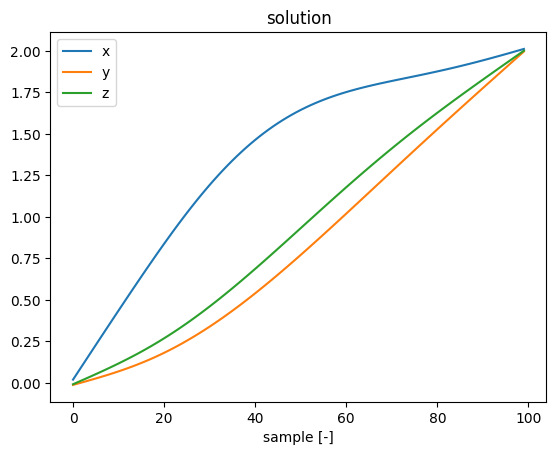

cost_qconf_ref: 0.0002513024702727588%
Contribution of costs: 
cost_obs:       0.0%
cost_torques:   0.9997644862754667%
cost_qconf_ref: 0.00023551372453338158%
Contribution of costs: 
cost_obs:       0.0%
cost_torques:   0.9997801332469651%
cost_qconf_ref: 0.00021986675303488105%
Contribution of costs: 
cost_obs:       0.0%
cost_torques:   0.9997956386188366%
cost_qconf_ref: 0.00020436138116337196%
Contribution of costs: 
cost_obs:       0.0%
cost_torques:   0.999811004130271%
cost_qconf_ref: 0.0001889958697289498%
Contribution of costs: 
cost_obs:       0.0%
cost_torques:   0.999826232988282%
cost_qconf_ref: 0.00017376701171793895%
Contribution of costs: 
cost_obs:       0.0%
cost_torques:   0.9998413297733918%
cost_qconf_ref: 0.00015867022660811657%
Contribution of costs: 
cost_obs:       0.0%
cost_torques:   0.9998563003488957%
cost_qconf_ref: 0.00014369965110430609%
Contribution of costs: 
cost_obs:       0.0%
cost_torques:   0.9998711517648566%
cost_qconf_ref: 0.000128848235143322

In [13]:
# plot results
using PyPlot

PyPlot.figure()
labels=["x","y","z"]
for dim in 1:p
    PyPlot.plot(Q[dim,:],label=labels[dim])
end
PyPlot.legend(loc="best")
PyPlot.xlabel("sample [-]"); PyPlot.title("solution")

# 6) compute total cost
Jtot = 0
Jacc = 0
for dim in 1:p
    Jacc = Jacc + 0.5 * Q[p,:]' * R * Q[p,:]
    Jtot = Jtot + 0.5 * Q[p,:]' * R * Q[p,:]
end
Jcosttot = 0
for nidx = 1:N
    Jcosttot = Jcosttot + cost(Q[:,nidx], nidx, nidx)
    Jtot = Jtot + cost_println(Q[:,nidx], nidx, nidx)
end

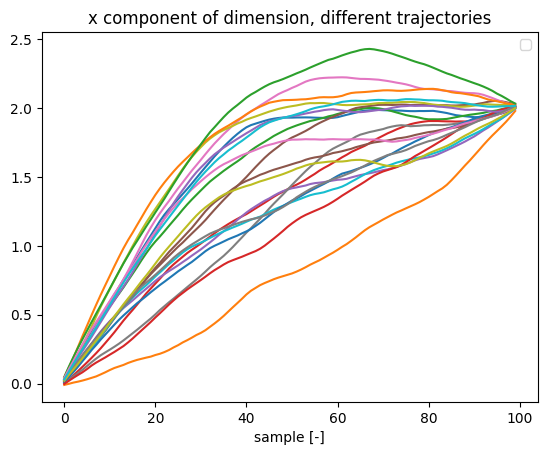

No handles with labels found to put in legend.


PyObject Text(0.5,1,'x component of dimension, different trajectories')

In [14]:
using PyPlot

# debug samples generation
Rinv = 0.5* (Rinv+Rinv')
Dist = MvNormal(zeros(N),Rinv) # create normal distribution


Qperturbed = zeros(p,N,K) # configuration trajectory (in time, length N) for each dimension
eps = zeros(p,N,K)
for kidx in 1:K # for each trajectory
    eps[:,:,kidx] = rand(Dist,p)'
    for dim in 1:p 
        # perturb all time samples of current trajectory and save in Qhere
        Qperturbed[dim,:,kidx]= Q[dim,:] + eps[dim,:,kidx]
    end
end

PyPlot.figure()
for kidx in 1:min(K,20)
    PyPlot.plot(Qperturbed[1,:,kidx])
end
PyPlot.legend(loc="best")
PyPlot.xlabel("sample [-]"); PyPlot.title("x component of dimension, different trajectories")

In [15]:
# plot scene
vis = Visualizer()

vis[:obstacles]
for (idx,obs) in enumerate(obstacles)
    setobject!(vis[:obstacles][Symbol(string("obs",idx))], 
        Object(obs,MeshBasicMaterial(color=RGBA(1.0,0.,0.,1.))))
end

vis[:robot]
setobject!(vis[:robot][:Astrobee], 
    Object(astrobee,MeshBasicMaterial(color=RGBA(0,1.0,0.,1.))))

# plot trajectory using GeometryTypes
#verts = Vector{Point3f0}(0)
verts = Vector{HyperSphere}(0)
colors = Vector{RGB{Float32}}(0)
for i in 1:N
    #k in find(not_in_collision) && continue
    #push!(verts, Point3f0(Q0[1:3,i]))
    push!(verts, HyperSphere(Point3f0(Q[1:3,i]), 0.01f0))
    push!(colors, RGB(1.,0.,1.))
    
    #setobject!(vis[:samples][:position], verts[i])
    setobject!(vis[:samples][Symbol(string("position",i))], 
        Object(verts[i],MeshBasicMaterial(color=colors[i])))
end
#setobject!(vis[:samples][:position], PointCloud(verts,colors))

in_cell = true
in_cell ? IJuliaCell(vis) : open(vis)

WebIO.Scope("scope-86263489-3d75-499c-8d95-411064681bd4", WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :iframe), Any[], Dict{Symbol,Any}(Pair{Symbol,Any}(:attributes, Dict{String,Any}(Pair{String,Any}("height", "100%"),Pair{String,Any}("scrolling", "no"),Pair{String,Any}("src", "javascript:void(0)"),Pair{String,Any}("frameborder", 0))),Pair{Symbol,Any}(:id, "ifr"),Pair{Symbol,Any}(:style, Dict("width"=>"100%","flexGrow"=>"1"))), 0)], Dict{Symbol,Any}(Pair{Symbol,Any}(:style, Dict("flexDirection"=>"column","height"=>"100%","minHeight"=>"400px","display"=>"flex","width"=>"100%","overflow"=>"hidden"))), 1), Dict{String,Tuple{Observables.Observable,Union{Bool, Void}}}(), Set{String}(), nothing, Any[], Dict{Any,Any}(Pair{Any,Any}("_promises", Dict{Any,Any}(Pair{Any,Any}("importsLoaded", Any[WebIO.JSString("function () {\n    var frame = this.dom.querySelector(\"#ifr\");\n    var doc = frame.contentDocument\n    var win = frame.contentWindow\n\n    // Determine if we're running on a Jupyter hosting service\n    // that requires a base URL when retrieving assets\n    var curMatch =\n        window.location.href\n        .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n    curMatch = curMatch ||\n        window.location.href\n        .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n    if (curMatch) {\n        var base = doc.createElement(\"base\");\n        base.setAttribute(\"href\", curMatch[1] + '/');\n        doc.head.appendChild(base);\n    }\n\n    var webio = doc.createElement(\"script\")\n    webio.src = \"pkg/WebIO/webio/dist/bundle.js\"\n    var parent = window\n\n    function resizeIframe() {\n        doc.body.style.padding = '0'\n        doc.body.style.margin = '0'\n        doc.documentElement.height = '100%'\n        doc.body.height = '100%'\n    }\n\n    webio.onload = function () {\n        win.WebIO.sendCallback = parent.WebIO.sendCallback; // Share stuff\n        win.WebIO.scopes = parent.WebIO.scopes\n        win.WebIO.obsscopes = parent.WebIO.obsscopes\n        win.WebIO._connected = true\n        doc.body.innerHTML = \"<html><body>\" + \"<div class='display:none'></div><unsafe-script style='display:none'>\\nWebIO.mount(this.previousSibling,{&quot;props&quot;:{},&quot;nodeType&quot;:&quot;Scope&quot;,&quot;type&quot;:&quot;node&quot;,&quot;instanceArgs&quot;:{&quot;imports&quot;:{&quot;data&quot;:[{&quot;name&quot;:null,&quot;type&quot;:&quot;js&quot;,&quot;url&quot;:&quot;/assetserver/0379911267104dfa5e4223bfb98a6fd107cd258a-main.min.js&quot;}],&quot;type&quot;:&quot;async_block&quot;},&quot;id&quot;:&quot;scope-15f1307d-de43-4b3e-9fd7-e2eab106f12e&quot;,&quot;handlers&quot;:{&quot;meshcat-command&quot;:[(function (val){return this.viewer.handle_command_message({&quot;data&quot;:val})})],&quot;_promises&quot;:{&quot;importsLoaded&quot;:[(function (mc){var element=this.dom.children[0]; this.viewer=new mc.Viewer(element); WebIO.setval({&quot;name&quot;:&quot;meshcat-request&quot;,&quot;scope&quot;:&quot;scope-15f1307d-de43-4b3e-9fd7-e2eab106f12e&quot;,&quot;id&quot;:&quot;ob_05&quot;,&quot;type&quot;:&quot;observable&quot;},String(Date.now())); return window.document.body.style.margin=&quot;0&quot;})]}},&quot;systemjs_options&quot;:null,&quot;observables&quot;:{&quot;meshcat-command&quot;:{&quot;sync&quot;:false,&quot;id&quot;:&quot;ob_04&quot;,&quot;value&quot;:[131,166,111,98,106,101,99,116,132,170,103,101,111,109,101,116,114,105,101,115,145,133,174,104,101,105,103,104,116,83,101,103,109,101,110,116,115,20,164,117,117,105,100,218,0,36,48,49,51,48,57,101,98,54,45,98,49,53,54,45,49,49,101,56,45,49,48,57,97,45,97,53,100,99,55,49,99,102,48,56,51,99,166,114,97,100,105,117,115,202,60,35,215,10,164,116,121,112,101,174,83,112,104,101,114,101,71,101,111,109,101,116,114,121,173,119,105,100,116,104,83,101,103,109,101,110,116,115,20,166,111,98,106,101,99,116,133,168,109,97,116,101,114,105,97,108,218,0,36,48,49,51,48,57,101,99,97,45,98,49,53,54,45,49,49,101,56,45,49,57,50,55,45,100,98,53,52,98,57,99,